<a href="https://colab.research.google.com/github/Zahidlab/OCT-Image-Denoising/blob/main/OCT_Image_Denoiser_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [121]:
import os
from os.path import join
import cv2
import sys
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt
from PIL import Image

In [87]:
# Find Out if the code is running in Google Colab

COLAB = 'google.colab' in sys.modules

#setting up Device for device agnostic code

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [88]:
#Mounting Google Drive and setting the Root Data Directory for Colab Environment

if COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  
  # Defining Data Path
  Root_Dir = '/content/drive/MyDrive/Research/OCT datasets'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
# Setting Specific data path for each different data folder
first_first = os.path.join(Root_Dir,'Fast Acuisition', 'For synthetic experiments')
first_second = os.path.join(Root_Dir,'Fast Acuisition', 'Images for Dictionaries and Mapping leraning')
second = os.path.join(Root_Dir, 'Sparsity Based Denoising... _SDOCT_DATASET_2012_AMD')


In [90]:

CLEAN_IMAGES = []
NOISY_IMAGES = []
IMAGE_PATHS = []
for folder in os.listdir(first_first):
  folder_path = os.path.join(first_first, folder)

  
  # clean_img = cv2.imread(join(folder_path, 'average.tif'), 0)
  # noisy_image = cv2.imread(join(folder_path, '1.tif'), 0)

  clean_img_path = join(folder_path, 'average.tif')
  noisy_image_path = join(folder_path, '1.tif')

  IMAGE_PATHS.append([noisy_image_path, clean_img_path])





In [91]:
len(IMAGE_PATHS)

18

In [124]:
class CustomDataset(Dataset):

  def __init__(self, paths, transform = None):
    self.paths = paths
    self.transform = transform

  def __getitem__(self, index:int, ):

    noisy_img = Image.open(self.paths[index][0])
    clean_img = Image.open(self.paths[index][1])
    clean_img = transforms.functional.adjust_sharpness(clean_img,sharpness_factor=20)

    if self.transform:
      return self.transform(noisy_img), self.transform(clean_img)

    return noisy_img, clean_img



  def __len__(self):
    return len(self.paths)



In [125]:
# defining Transforms Needed to be done on the Images
trans = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Resize((128,128)),

    transforms.ToTensor(),
    # transforms.Normalize((0.5), (0.5))
])

In [126]:
# Dataset 
dataset = CustomDataset(IMAGE_PATHS, transform = trans)
len(dataset)

18

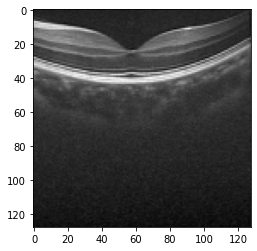

In [127]:
plt.imshow(dataset[1][1].squeeze(), cmap = 'gray')

## BATCH SIZE

In [128]:
BATCH_SIZE = 8

## Data Loader

In [129]:
train_dl = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True)


In [130]:
n,c = next(iter(train_dl))
n.shape, c.shape

(torch.Size([8, 1, 128, 128]), torch.Size([8, 1, 128, 128]))

# Model Creation and Training Testing

## Model class

In [131]:
class AutoEncoder_CNN(nn.Module):

  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        
        nn.Conv2d(1, 16, 3, 2,1),    #N, 16, 14, 14 
        nn.ReLU(),

        nn.Conv2d(16, 32, 3, 2,1),      #N, 32, 7, 7 
        nn.ReLU(),

        nn.Conv2d(32, 64, 7),  #N, 64, 1, 1

 
    )


    self.decoder = nn.Sequential(
        
        nn.ConvTranspose2d(64, 32, 7),    #N, 32, 7, 7
        nn.ReLU(),

        nn.ConvTranspose2d(32, 16, 3, stride = 2, padding = 1, output_padding = 1),   #N, 16, 14, 14
        nn.ReLU(),

        nn.ConvTranspose2d(16, 1, 3, stride = 2, padding = 1, output_padding = 1),   #N, 1, 28, 28


        nn.Sigmoid()
    )



  def forward(self, x):
    encoded = self.encoder(x)
    # print(f"Shape of encoded: {encoded.shape}")
    decoded = self.decoder(encoded)
    return decoded

In [132]:
model = AutoEncoder_CNN()
EPOCHS = 100
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=1e-5)

In [133]:
LOGS = []

for epoch in range(EPOCHS):

  for (noisy, clean) in train_dl:
    # img = img.reshape(-1, 28*28)

    # print(img.shape)
    result = model(noisy)
    # print(f"img shape: {img.shape}")
    # print(f"pred shape: {result.shape}")
    loss = loss_fn(result, clean)

    optim.zero_grad()
    loss.backward()
    optim.step()

  
  print(f"\u001b[31mEpoch: {epoch+1} | Loss: {loss.item():.4f}")
  LOGS.append(loss.item())

# print(f"img shape: {result.shape}")
# print(f"pred shape: {result.shape}")

Epoch: 1 | Loss: 0.0428
Epoch: 2 | Loss: 0.0309
Epoch: 3 | Loss: 0.0244
Epoch: 4 | Loss: 0.0254
Epoch: 5 | Loss: 0.0214
Epoch: 6 | Loss: 0.0155
Epoch: 7 | Loss: 0.0129
Epoch: 8 | Loss: 0.0120
Epoch: 9 | Loss: 0.0110
Epoch: 10 | Loss: 0.0091
Epoch: 11 | Loss: 0.0093
Epoch: 12 | Loss: 0.0091
Epoch: 13 | Loss: 0.0073
Epoch: 14 | Loss: 0.0079
Epoch: 15 | Loss: 0.0078
Epoch: 16 | Loss: 0.0061
Epoch: 17 | Loss: 0.0068
Epoch: 18 | Loss: 0.0058
Epoch: 19 | Loss: 0.0053
Epoch: 20 | Loss: 0.0055
Epoch: 21 | Loss: 0.0042
Epoch: 22 | Loss: 0.0044
Epoch: 23 | Loss: 0.0042
Epoch: 24 | Loss: 0.0050
Epoch: 25 | Loss: 0.0050
Epoch: 26 | Loss: 0.0042
Epoch: 27 | Loss: 0.0036
Epoch: 28 | Loss: 0.0042
Epoch: 29 | Loss: 0.0038
Epoch: 30 | Loss: 0.0035
Epoch: 31 | Loss: 0.0035
Epoch: 32 | Loss: 0.0031
Epoch: 33 | Loss: 0.0051
Epoch: 34 | Loss: 0.0039
Epoch: 35 | Loss: 0.0040
Epoch: 36 | Loss: 0.0042
Epoch: 37 | Loss: 0.0044
Epoch: 38 | Loss: 0.0044
Epoch: 39 | Loss: 0.0033
Epoch: 40 | Loss: 0.0033
Epoch: 41

In [134]:
with torch.inference_mode():
  res = model(n)

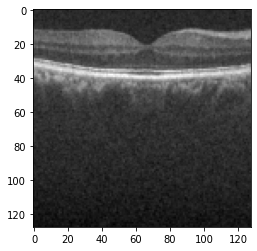

In [135]:
plt.imshow(n[0].squeeze(), cmap='gray')

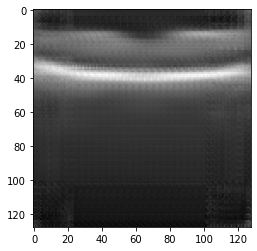

In [136]:
plt.imshow(res[0].squeeze(), cmap='gray')

(-0.5, 127.5, 127.5, -0.5)

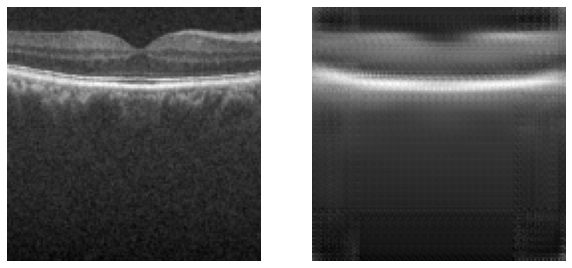

In [137]:
fig = plt.figure(figsize = (10,10))

fig.add_subplot(1,2,1)
plt.imshow(n[0].squeeze(), cmap='gray')
plt.axis('off')

fig.add_subplot(1,2,2)
plt.imshow(res[0].squeeze(), cmap='gray')
plt.axis('off')